In [1]:
%run -i setup_stats.py
%matplotlib inline


# Other Graphics

In [2]:
tree0 = cmap[0]
tree1 = cmap[6]
tree2 = cmap[2]
tree3 = cmap[3]
tree3o = cmap[4]
treel = cmap[1]

colors = [tree0, tree1, tree2, tree3, tree3o]

(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/generateConfigurations/statistics/dualcore-A-13-x-100-x-10")

# plot total cost depending on memory size for a figure in the beginning of the paper
invA = prepare_diff_memory_cost(df, "A", False, 1675346654) # A is waiting for a lot of other function
invG = prepare_diff_memory_cost(df, "G", False, 1675346654) # G is calculating stuff

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


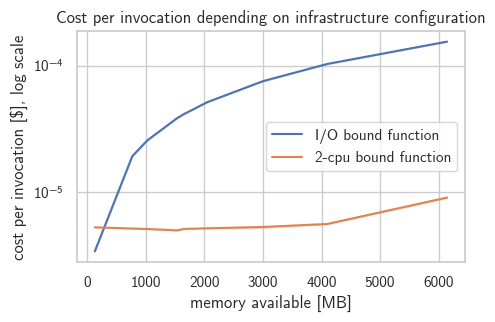

In [3]:
sns.lineplot(data=invA, x="memoryAvail", y="totalCost", label="I/O bound function")
sns.lineplot(data=invG, x="memoryAvail", y="totalCost", label="2-cpu bound function")
plt.title(f"Cost per invocation depending on infrastructure configuration")
plt.xlabel("memory available [MB]")
plt.ylabel("cost per invocation [$], log scale")
plt.yscale("log")
ax = plt.gca()
#save_fig(ax, "compareIOBoundCPUBound")
plt.show()

In [4]:
meanA = invA["totalCost"].mean()
meanG = invG["totalCost"].mean()

invA["totalCostPercentOfMean"] = (invA["totalCost"] - meanA)/meanA
invG["totalCostPercentOfMean"] = (invG["totalCost"] - meanG)/meanG

invA = invA.loc[(invA["memoryAvail"] >= 100)&(invA["memoryAvail"] <= 4000)]
invG = invG.loc[(invG["memoryAvail"] >= 100)&(invG["memoryAvail"] <= 4000)]

/tmp/ipykernel_21611/1314456129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invA["totalCostPercentOfMean"] = (invA["totalCost"] - meanA)/meanA
/tmp/ipykernel_21611/1314456129.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invG["totalCostPercentOfMean"] = (invG["totalCost"] - meanG)/meanG


TeX  NOT subset; don't know how to subset; dropped


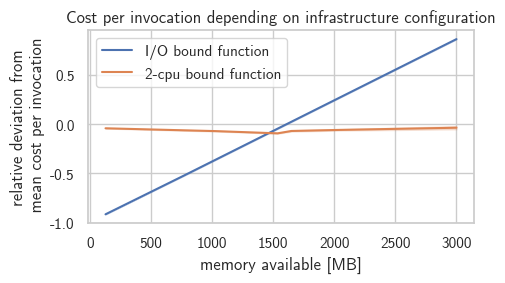

In [5]:


sns.lineplot(data=invA, x="memoryAvail", y="totalCostPercentOfMean", label="I/O bound function")
sns.lineplot(data=invG, x="memoryAvail", y="totalCostPercentOfMean", label="2-cpu bound function")
plt.title(f"Cost per invocation depending on infrastructure configuration")
plt.xlabel("memory available [MB]")
plt.ylabel("relative deviation from\n mean cost per invocation")
#plt.yscale("log")
ax = plt.gca()
save_fig(ax, "compareIOBoundCPUBound")
plt.show()

# Split Prepare

In [6]:
tree0 = cmap[0]
tree1 = cmap[6]
tree2 = cmap[2]
tree3 = cmap[3]
tree3o = cmap[4]
treel = cmap[1]

colors = [tree0, tree1, tree2, tree3, tree3o]

# Split Normal Old

In [7]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/generateConfigurations/statistics/dualcore-A-13-x-100-x-10")

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


In [8]:
# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "1675344670": "Tree$_0$",
    "1675345536": "Tree$_1$",
    "1675346078": "Tree$_2$",
    "1675346654": "Tree$_{3 (Path)}$", # (128MB)
    "1675347190": "Tree$_3$ (768MB)",
    "1675347701": "Tree$_3$ (1024MB)",
    "1675348211": "Tree$_3$ (1536MB)",
    "1675348735": "Tree$_3$ (1650MB)",
    "1675349244": "Tree$_3$ (2048MB)",
    "1675349754": "Tree$_3$ (3000MB)",
    "1675350261": "Tree$_3$ (4096MB)",
    "1675350785": "Tree$_3$ (6144MB)",
    "1675351296": "Tree$_{3 (Optim)}$",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

# Only show the initial 3 and optimal fusion group
cond = (grouped['fusionGroup', 'min'] < 1675347190) | (grouped['fusionGroup', 'min'] == 1675351296)
grouped_filtered = grouped[cond]

cond = (df['fusionGroup'] < 1675347190) | (df['fusionGroup'] == 1675351296)
df_filtered = df[cond]


TeX  NOT subset; don't know how to subset; dropped


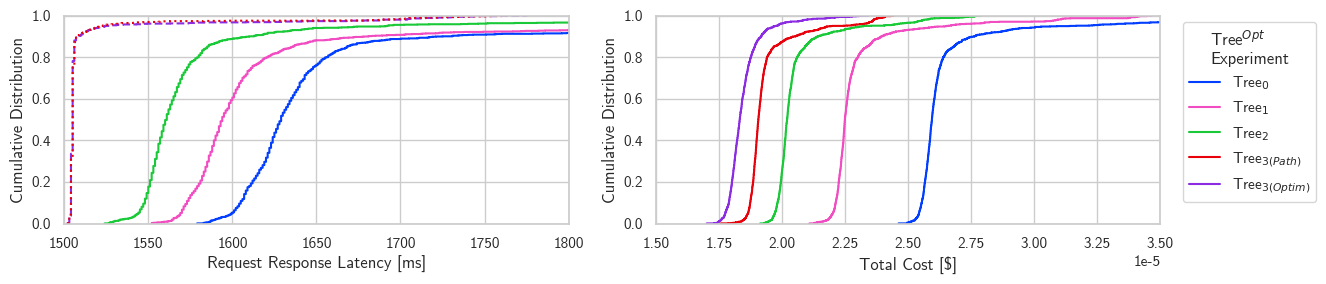

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.set_xlim(1500, 1800)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
ax2.set_xlim(0.000015, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

sns.ecdfplot(ax=ax1, data=grouped_filtered, x=grouped_filtered['rootDuration'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped_filtered, x=grouped_filtered['totalCost', 'sum'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)

ax1.lines[0].set_linestyle("--")
ax1.lines[1].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=["Tree$_0$", "Tree$_1$", "Tree$_2$", "Tree$_{3 (Path)}$", "Tree$_{3 (Optim)}$"],title="Tree$^{Opt}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.11, 0.35, 1, 0.5))
save_fig(fig, "split/allNormal")

In [10]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 1545.0899584807012, Confidence Interval: (1541.8135624731028 / 1548.3663544882995), Median: 1505.0 for rootDuration
Mean: 4687.344610179917, Confidence Interval: (4618.713832589083 / 4755.975387770752), Median: 2201.0 for billedDuration
Mean: 5.8163094776928254e-05, Confidence Interval: (5.7369698534801534e-05 / 5.8956491019054974e-05), Median: 4.09942153216e-05 for totalCost
------ 1675344670/['Tree$_0$']
 minmem: [128]
Mean: 1755.861, Confidence Interval: (1723.6964776522382 / 1788.025522347762), Median: 1629.0 for rootDuration
Mean: 12529.3, Confidence Interval: (12441.927854487594 / 12616.672145512404), Median: 12158.0 for billedDuration
Mean: 2.672922679168e-05, Confidence Interval: (2.6542832508465716e-05 / 2.6915621074894285e-05), Median: 2.59371185408e-05 for totalCost
------ 1675345536/['Tree$_1$']
 minmem: [128]
Mean: 1669.09, Confidence Interval: (1649.4913326678823 / 1688.6886673321176), Median: 1594.0 for rootDuration
Mean: 10793.154, Confidence Interv

------ 1675350785/['Tree$_3$ (6144MB)']
 minmem: [6144]
Mean: 1505.3926073926075, Confidence Interval: (1505.1806122495632 / 1505.6046025356518), Median: 1505.0 for rootDuration
Mean: 1761.3196803196804, Confidence Interval: (1759.509365732275 / 1763.1299949070858), Median: 1753.0 for billedDuration
Mean: 0.0001803594959830058, Confidence Interval: (0.00018017411939850306 / 0.00018054487256750855), Median: 0.00017950755901439998 for totalCost
------ 1675351296/['Tree$_{3 (Optim)}$']
 minmem: [128]
Mean: 1512.4525474525474, Confidence Interval: (1510.2137414807546 / 1514.6913534243402), Median: 1505.0 for rootDuration
Mean: 2210.826173826174, Confidence Interval: (2207.0310099229623 / 2214.6213377293857), Median: 2197.0 for billedDuration
Mean: 1.8476653669850152e-05, Confidence Interval: (1.8430338196011074e-05 / 1.852296914368923e-05), Median: 1.83168366336e-05 for totalCost


# Split Normal New

# Split Cold Starts Old

In [11]:
colors = [tree0, tree3, tree3o, treel]

In [12]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/coldStarts/statistics/dualcore-4")
new_fs_names = {
    "a_remote": "Tree$_{remote}$",
    "d_optimal_small": "Tree$_{Path}$", # (128MB)
    "c_optimal": "Tree$_{Optim}$",
    "b_local": "Tree$_{local}$" # Maybe comment this out...
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


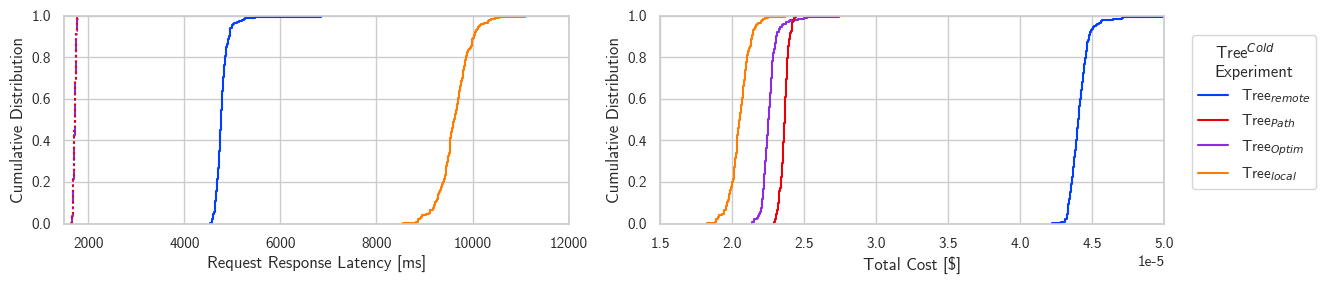

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
ax1.set_xlim(1500, 12000)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
ax2.set_xlim(0.000015, 0.00005)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ["Tree$_{remote}$", "Tree$_{Path}$", "Tree$_{Optim}$", "Tree$_{local}$"]
sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)

ax1.lines[2].set_linestyle(":") # '-', '--', '-.', ':'
ax1.lines[1].set_linestyle("-.")

fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, title="Tree$^{Cold}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.11, 0.35, 1, 0.5))
save_fig(fig, "split/allCold")


In [14]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 4464.635, Confidence Interval: (4239.519921116199 / 4689.7500788838015), Median: 3178.0 for rootDuration
Mean: 11001.33125, Confidence Interval: (10552.979761036922 / 11449.682738963076), Median: 10742.5 for billedDuration
Mean: 2.7735743471376e-05, Confidence Interval: (2.707175795092897e-05 / 2.839972899182303e-05), Median: 2.3205379744e-05 for totalCost
------ a_remote/['Tree$_{remote}$']
 minmem: [128]
Mean: 4790.195, Confidence Interval: (4763.415223128763 / 4816.974776871237), Median: 4762.5 for rootDuration
Mean: 20692.375, Confidence Interval: (20634.00028443287 / 20750.74971556713), Median: 20644.0 for billedDuration
Mean: 4.41438216208e-05, Confidence Interval: (4.401928864519134e-05 / 4.426835459640866e-05), Median: 4.4040621414400004e-05 for totalCost
------ b_local/['Tree$_{local}$']
 minmem: [128]
Mean: 9631.275, Confidence Interval: (9584.398984886651 / 9678.151015113348), Median: 9620.0 for rootDuration
Mean: 9634.345, Confidence Interval: (9587.395

# Split Cold Start New

# Split Bursty Workload Old

In [15]:
# Bursty Workload
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/split/manualOptimizerConstantLoad/statistics/bursty_workload-4")
new_fs_names = {
    "a_remote": "Tree$_{remote}$",
    "d_optimal_small": "Tree$_{Path}$", # (128MB)
    "c_optimal": "Tree$_{Optim}$",
    "b_local": "Tree$_{local}$" # Maybe comment this out...
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


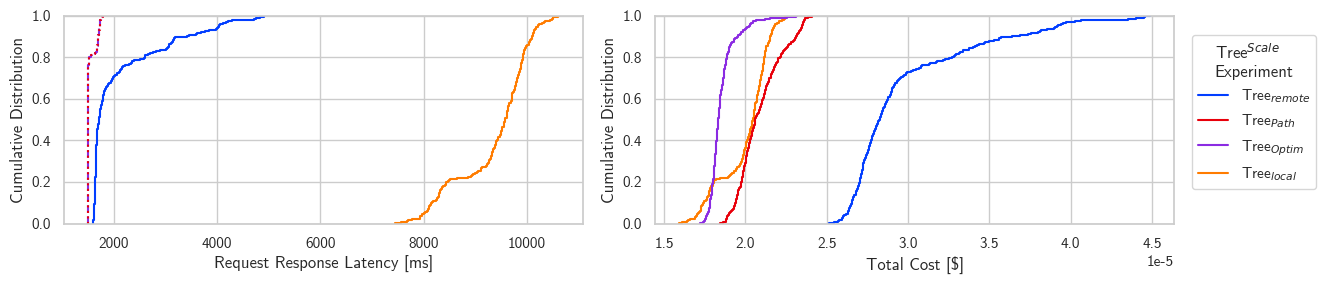

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ["Tree$_{remote}$", "Tree$_{Path}$", "Tree$_{Optim}$","Tree$_{local}$"]

sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)

ax1.lines[1].set_linestyle("--")
ax1.lines[2].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, title="Tree$^{Scale}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.11, 0.35, 1, 0.5))
save_fig(fig, "split/bursty")

In [17]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 3184.063400576369, Confidence Interval: (3023.6487918964876 / 3344.4780092562505), Median: 1648.0 for rootDuration
Mean: 8809.773775216137, Confidence Interval: (8571.706684574412 / 9047.840865857863), Median: 9633.0 for billedDuration
Mean: 2.2509799486367724e-05, Confidence Interval: (2.223927957910562e-05 / 2.278031939362983e-05), Median: 2.05803078272e-05 for totalCost
------ a_remote/['Tree$_{remote}$']
 minmem: [128]
Mean: 2122.976, Confidence Interval: (2042.3457461577566 / 2203.606253842244), Median: 1720.0 for rootDuration
Mean: 13982.872, Confidence Interval: (13785.457934182963 / 14180.286065817036), Median: 13246.0 for billedDuration
Mean: 2.9830186593587208e-05, Confidence Interval: (2.9409035744210847e-05 / 3.0251337442963568e-05), Median: 2.82581898496e-05 for totalCost
------ b_local/['Tree$_{local}$']
 minmem: [128]
Mean: 9369.285171102661, Confidence Interval: (9282.61049312722 / 9455.959849078103), Median: 9581.0 for rootDuration
Mean: 9373.86692

# IoT Preparation

In [18]:
cmap = sns.color_palette("bright", 9, as_cmap=True)
iot0 = cmap[0]
iot1 = cmap[6]
iot2 = cmap[2]
iot3 = cmap[3]
iot4 = cmap[4]
iot5 = cmap[1]
iot5o = cmap[9]
iotl = cmap[8]

# IoT Normal Old

In [19]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/IoT/generateConfigurations/statistics/dualcore-I-100x10x11")

# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "1676018871": "IoT$_0$",
    "1676019806": "IoT$_1$",
    "1676020374": "IoT$_2$",
    "1676020922": "IoT$_3$",
    "1676021466": "IoT$_4$",
    "1676021998": "IoT$_{5 (Path)}$", # (128MB)
    "1676022528": "IoT$_5$ (768 MB)",
    "1676023227": "IoT$_5$ (1024 MB)",
    "1676024794": "IoT$_5$ (1536 MB)",
    "1676025759": "IoT$_5$ (1650 MB)",
    "1676026378": "IoT$_5$ (2048 MB)",
    "1676026914": "IoT$_{5 (Optim)}$",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

# Only show the initial 3 and optimal fusion group
cond = (grouped['fusionGroup', 'min'] <= 1676021998) | (grouped['fusionGroup', 'min'] == 1676026914)
grouped_filtered = grouped[cond]

cond = (df['fusionGroup'] <= 1675347190) | (df['fusionGroup'] == 1675351296)
df_filtered = df[cond]

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


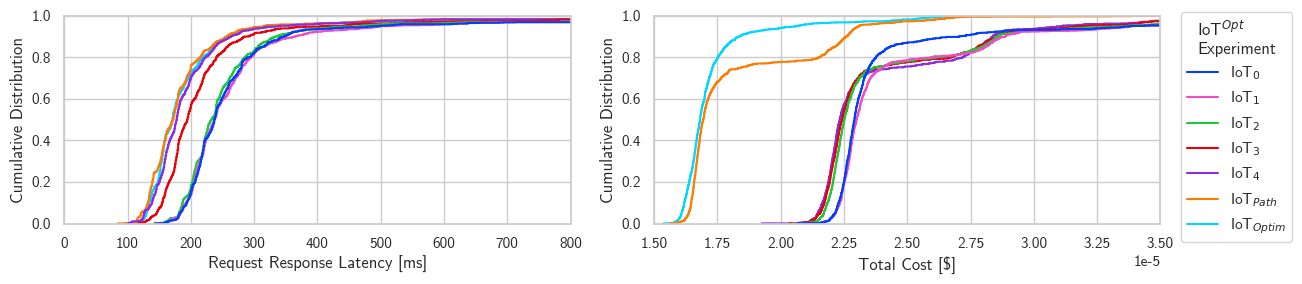

In [20]:
colors = [iot0, iot1, iot2, iot3, iot4, iot5, iot5o]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.set_xlim(0, 800)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
ax2.set_xlim(0.000015, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

sns.ecdfplot(ax=ax1, data=grouped_filtered, x=grouped_filtered['rootDuration'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped_filtered, x=grouped_filtered['totalCost', 'sum'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)

#ax1.lines[0].set_linestyle("--")
#ax1.lines[1].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=["IoT$_0$", "IoT$_1$", "IoT$_2$", "IoT$_3$", "IoT$_4$", "IoT$_{Path}$", "IoT$_{Optim}$"], title="IoT$^{Opt}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.09, 0.30, 1, 0.5))
save_fig(fig, "iot/allNormal")

In [21]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 172.51503289747646, Confidence Interval: (168.95400672967156 / 176.07605906528136), Median: 157.0 for rootDuration
Mean: 6335.885067044224, Confidence Interval: (6246.609328259519 / 6425.160805828929), Median: 7651.0 for billedDuration
Mean: 2.138879448345272e-05, Confidence Interval: (2.1315245158150072e-05 / 2.1462343808755366e-05), Median: 2.1615043230000003e-05 for totalCost
------ 1676018871/['IoT$_0$']
 minmem: [128]
Mean: 298.806, Confidence Interval: (280.6727940550899 / 316.93920594491004), Median: 237.0 for rootDuration
Mean: 11389.649, Confidence Interval: (11257.863078335855 / 11521.434921664144), Median: 10738.5 for billedDuration
Mean: 2.4297966462502402e-05, Confidence Interval: (2.401682260066563e-05 / 2.4579110324339175e-05), Median: 2.2908845817600002e-05 for totalCost
------ 1676019806/['IoT$_1$']
 minmem: [128]
Mean: 301.8061938061938, Confidence Interval: (283.57498737681817 / 320.0374002355694), Median: 237.0 for rootDuration
Mean: 11631.77322

# IoT Coldstarts Old

In [22]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/IoT/coldStarts/statistics/dualcore")

# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "a_remote": "IoT$_{remote}$",
    "b_local": "IoT$_{local}$",
    "c_optimal_small": "IoT$_{Path}$",
    "c_optimal": "IoT$_{Optim}$",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


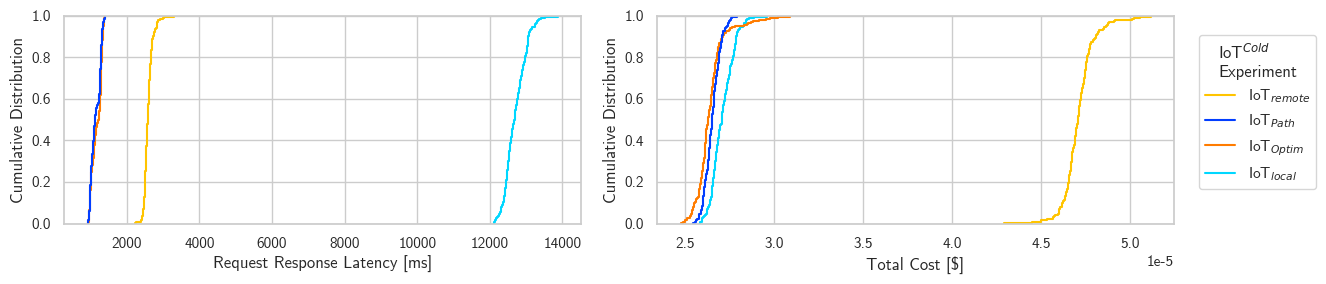

In [23]:
colors = [iotl, iot0, iot5, iot5o]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ["IoT$_{remote}$", "IoT$_{Path}$", "IoT$_{Optim}$","IoT$_{local}$"]
sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)

#ax1.lines[2].set_linestyle("-.")
#ax1.lines[1].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, title="IoT$^{Cold}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.11, 0.35, 1, 0.5))
save_fig(fig, "iot/allCold")

In [24]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 4404.50125, Confidence Interval: (4068.928145696645 / 4740.074354303355), Median: 1812.5 for rootDuration
Mean: 14236.17375, Confidence Interval: (13910.005205197896 / 14562.342294802103), Median: 12530.5 for billedDuration
Mean: 3.180235739625425e-05, Confidence Interval: (3.1185285664862046e-05 / 3.241942912764646e-05), Median: 2.68576537152e-05 for totalCost
------ a_remote/['IoT$_{remote}$']
 minmem: [128]
Mean: 2590.475, Confidence Interval: (2573.311108845795 / 2607.638891154205), Median: 2574.5 for rootDuration
Mean: 22094.015, Confidence Interval: (22034.687677554277 / 22153.342322445722), Median: 22079.0 for billedDuration
Mean: 4.7133992934464e-05, Confidence Interval: (4.700742772678321e-05 / 4.7260558142144784e-05), Median: 4.7101960870400006e-05 for totalCost
------ b_local/['IoT$_{local}$']
 minmem: [128]
Mean: 12706.645, Confidence Interval: (12665.429225340149 / 12747.860774659852), Median: 12681.5 for rootDuration
Mean: 12710.5, Confidence Interval

# IoT Bursty Old

In [25]:
colors = [iot0, iot5, iot5o, iotl]
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/IoT/manualOptimizerConstantLoad/statistics/bursty_workload-4")
new_fs_names = {
    "a_remote": "IoT$_{remote}$",
    "c_optimal_small": "IoT$_{Path}$",
    "c_optimal": "IoT$_{Optim}$",
    "b_local": "IoT$_{local}$"
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


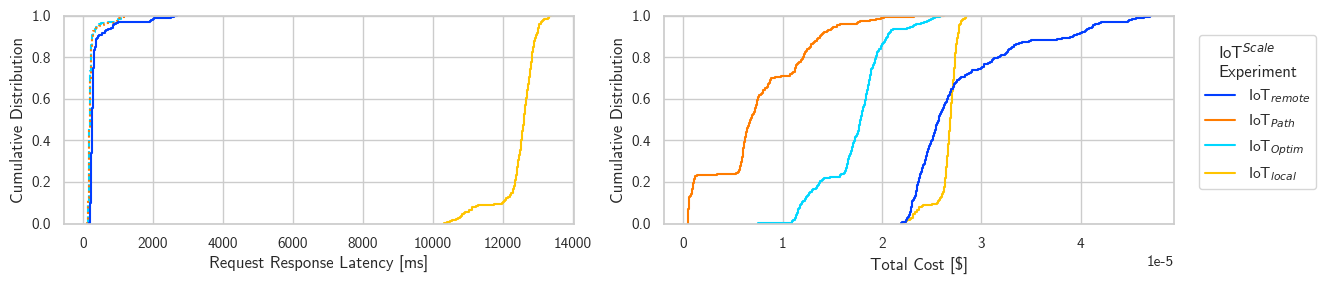

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

#ax1.set_xlim(0, 60000)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.0, 0.0002)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ["IoT$_{remote}$", "IoT$_{Path}$", "IoT$_{Optim}$", "IoT$_{local}$"]

sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)

ax1.lines[1].set_linestyle("--")
ax1.lines[2].set_linestyle(":")

fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, title="IoT$^{Scale}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.11, 0.35, 1, 0.5))
save_fig(fig, "iot/bursty")

In [27]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 2808.9473244147157, Confidence Interval: (2546.4866093871274 / 3071.408039442304), Median: 241.0 for rootDuration
Mean: 8394.240349599417, Confidence Interval: (8147.9851389319965 / 8640.495560266838), Median: 7299.0 for billedDuration
Mean: 1.9199769887688276e-05, Confidence Interval: (1.8699451719818965e-05 / 1.9700088055557587e-05), Median: 1.9856173045600003e-05 for totalCost
------ a_remote/['IoT$_{remote}$']
 minmem: [128]
Mean: 356.8186666666667, Confidence Interval: (320.8393077439471 / 392.79802558938627), Median: 262.0 for rootDuration
Mean: 13106.312, Confidence Interval: (12827.917644574696 / 13384.706355425304), Median: 12061.0 for billedDuration
Mean: 2.7960188186931204e-05, Confidence Interval: (2.736627904087464e-05 / 2.8554097332987767e-05), Median: 2.57301847936e-05 for totalCost
------ b_local/['IoT$_{local}$']
 minmem: [128]
Mean: 12473.508064516129, Confidence Interval: (12402.51455723194 / 12544.501571800318), Median: 12597.5 for rootDuration


['a_remote' 'b_local' 'c_optimal_small' 'c_optimal']


<Axes: xlabel='billedDuration', ylabel='Proportion'>

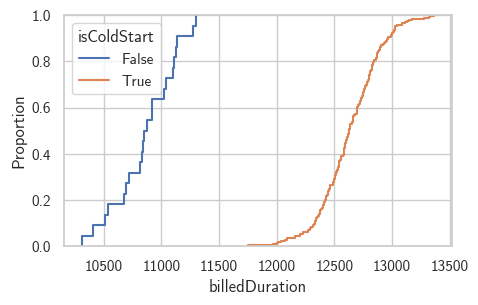

In [28]:
print(df["fusionGroup"].unique())
sns.ecdfplot(data=df.loc[df["isRootInvocation"] & (df["fusionGroup"] == "b_local")], x="billedDuration", hue="isColdStart")

# Webshop

In [29]:
cmap = sns.color_palette("bright", 9, as_cmap=True)
shop0 = cmap[0]
shop13s = cmap[6]
shop13_15 = cmap[2]
shop13_16 = cmap[3]
shop13_o = cmap[4]
shop13 = cmap[1]
shopl = cmap[9]

# Webshop Normal Old

In [42]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/webshop/generateConfigurations/statistics/fixedcheckout-m-4-x-111-x-3")

new_fs_names = {
    "1676375682": "Shop$_0$",
    "1676376424": "Shop$_1$",
    "1676376883": "Shop$_2$",
    "1676377347": "Shop$_3$",
    "1676377830": "Shop$_4$",
    "1676378281": "Shop$_5$",
    "1676378737": "Shop$_6$",
    "1676379194": "Shop$_7$",
    "1676379640": "Shop$_8$",
    "1676383303": "Shop$_9$",
    "1676383779": "Shop$_{10}$",
    "1676385324": "Shop$_{11}$",
    "1676387708": "Shop$_{12}$",
    "1676388535": "Shop$_{13 (Path)}$", ##
    "1676389085": "Shop$_{13 (1536 MB)}$", ## This is the first one with different memory sizes? 1676389085
    "1676389591": "Shop$_{13 (1650 MB)}$",
    "1676390159": "Shop$_{13 (Optim)}$"
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

# Only show the initial 3 and optimal fusion group
cond = (grouped['fusionGroup', 'min'] <= 1676375682) | (grouped['fusionGroup', 'min'] >= 1676389085)
grouped_filtered = grouped[cond]

cond = (df['fusionGroup'] <= 1676375682) | (df['fusionGroup'] >= 1676389085)
df_filtered = df[cond]

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


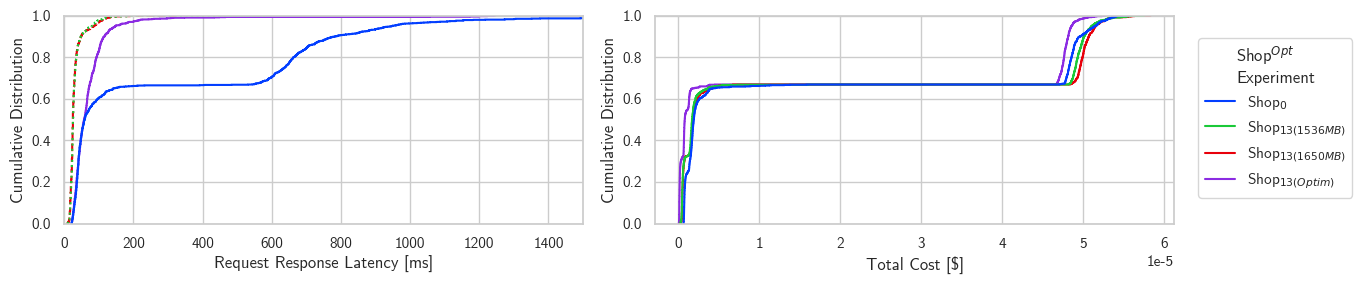

In [45]:
colors = [shop0, shop13_15, shop13_16, shop13_o]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))

ax1.set_xlim(0, 1500)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.0000, 0.000004)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

sns.ecdfplot(ax=ax1, data=grouped_filtered, x=grouped_filtered['rootDuration'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped_filtered, x=grouped_filtered['totalCost', 'sum'], hue=grouped_filtered['fusionGroupLabel'], palette=colors, legend=None)

ax1.lines[1].set_linestyle("--")
ax1.lines[2].set_linestyle(":")
labels=["Shop$_0$", "Shop$_{13 (1536 MB)}$", "Shop$_{13 (1650 MB)}$", "Shop$_{13 (Optim)}$"]

fig.legend(handles=reversed(ax2.get_lines()),labels=labels, title="Shop$^{Opt}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.14, 0.33, 1, 0.5))
save_fig(fig, "webshop/allNormal")

In [32]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 127.20164873713752, Confidence Interval: (123.19741390894237 / 131.20588356533267), Median: 51.0 for rootDuration
Mean: 6715.585301683816, Confidence Interval: (6564.247379722767 / 6866.923223644866), Median: 559.0 for billedDuration
Mean: 1.7074571502910066e-05, Confidence Interval: (1.6732627594782463e-05 / 1.741651541103767e-05), Median: 1.3738694144e-06 for totalCost
------ 1676375682/['Shop$_0$']
 minmem: [128]
Mean: 320.90168818272093, Confidence Interval: (288.7853881170582 / 353.0179882483837), Median: 59.0 for rootDuration
Mean: 8234.035749751738, Confidence Interval: (7581.602461118284 / 8886.469038385192), Median: 907.0 for billedDuration
Mean: 1.756597806468957e-05, Confidence Interval: (1.617411759855617e-05 / 1.8957838530822972e-05), Median: 1.9349372032e-06 for totalCost
------ 1676376424/['Shop$_1$']
 minmem: [128]
Mean: 305.02284011916583, Confidence Interval: (275.9908051612426 / 334.0548750770891), Median: 59.0 for rootDuration
Mean: 8223.1489572

Mean: 1.6810157949940812e-05, Confidence Interval: (1.539275382976212e-05 / 1.8227562070119506e-05), Median: 8.32001664e-07 for totalCost
------ 1676385324/['Shop$_{11}$']
 minmem: [128]
Mean: 77.14143426294821, Confidence Interval: (70.30433240182127 / 83.97853612407515), Median: 56.0 for rootDuration
Mean: 7877.449203187251, Confidence Interval: (7212.346098802702 / 8542.552307571801), Median: 398.5 for billedDuration
Mean: 1.6805258577249404e-05, Confidence Interval: (1.538636911678912e-05 / 1.822414803770969e-05), Median: 8.501350336000001e-07 for totalCost
------ 1676387708/['Shop$_{12}$']
 minmem: [128]
Mean: 74.82621648460774, Confidence Interval: (68.39547249503883 / 81.25696047417665), Median: 55.0 for rootDuration
Mean: 7833.762661370407, Confidence Interval: (7173.334908829094 / 8494.19041391172), Median: 394.0 for billedDuration
Mean: 1.6712060434977557e-05, Confidence Interval: (1.530314507839768e-05 / 1.8120975791557436e-05), Median: 8.405350144e-07 for totalCost
------ 1

In [33]:
# Problem: Why is the webshop two distributions next to each other?
# Maybe it's because of cold starts?
#onlyOneFg = df[(df['fusionGroup'] == 1676375682)]

In [34]:
#for i in df["currentTask"].unique():
    #filtered = onlyOneFg[(onlyOneFg["currentTask"] == i)]
    #sns.ecdfplot(data=filtered, x='billedDuration', palette=colors).set(title=i)
    #plt.show()

# Webshop Normal New

# Webshop Cold Old

In [41]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/webshop/coldStarts/statistics/oldDistJun--4")

# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "a_remote": "Shop$_{remote}$",
    "b_local": "Shop$_{local}$",
    #"c_opt_small": "Shop$_{13}$",
    "c_opt": "Shop$_{Optim}$",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


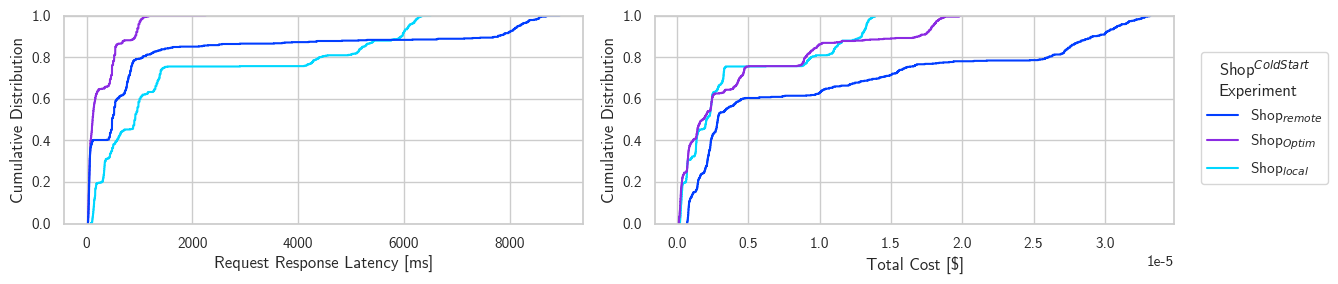

In [36]:
colors = [shop0, shop13_o, shopl]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ["Shop$_{remote}$", "Shop$_{Optim}$","Shop$_{local}$"]
sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)


fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, title="Shop$^{Cold Start}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.12, 0.33, 1, 0.5))
save_fig(fig, "webshop/allCold")

In [37]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 946.0090293453725, Confidence Interval: (871.0293391562649 / 1020.9887195344801), Median: 340.0 for rootDuration
Mean: 2429.1136158701534, Confidence Interval: (2284.9644802036914 / 2573.2627515366153), Median: 1000.0 for billedDuration
Mean: 5.788857745411001e-06, Confidence Interval: (5.4691713274645035e-06 / 6.108544163357498e-06), Median: 2.3317379968e-06 for totalCost
------ a_remote/['Shop$_{remote}$']
 minmem: [128]
Mean: 1400.8594594594595, Confidence Interval: (1190.5455063605584 / 1611.1734125583605), Median: 480.0 for rootDuration
Mean: 4672.4882882882885, Confidence Interval: (4240.138127994484 / 5104.8384485820925), Median: 1347.0 for billedDuration
Mean: 9.967994950965046e-06, Confidence Interval: (9.045646097644247e-06 / 1.0890343804285845e-05), Median: 2.8736057472000002e-06 for totalCost
------ b_local/['Shop$_{local}$']
 minmem: [128]
Mean: 1811.8954954954954, Confidence Interval: (1634.5394356290558 / 1989.251555361935), Median: 918.0 for rootDur

# Webshop Burst Old

In [38]:
(df, grouped, fusion_groups_order) = get_df_grouped("evalScripts/webshop/manualOptimizerConstantLoad/statistics/highload-bursty_workload_oldDistJun-4")

# Use same df from above: Total cost for the split test, but only optimal memory size
new_fs_names = {
    "a_remote": "Shop$_{remote}$",
    "b_local": "Shop$_{local}$",
    #"c_opt_small": "Shop$_{13}$",
    "c_opt": "Shop$_{Optim}$",
}

df["fusionGroupLabel"] = df["fusionGroup"].map(new_fs_names)
grouped['fusionGroupLabel'] = grouped['fusionGroup', 'min'].astype(str).map(new_fs_names)

/home/trever/git/umbrellerde/functionfusion/statistics/extended/setup_stats.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


TeX  NOT subset; don't know how to subset; dropped


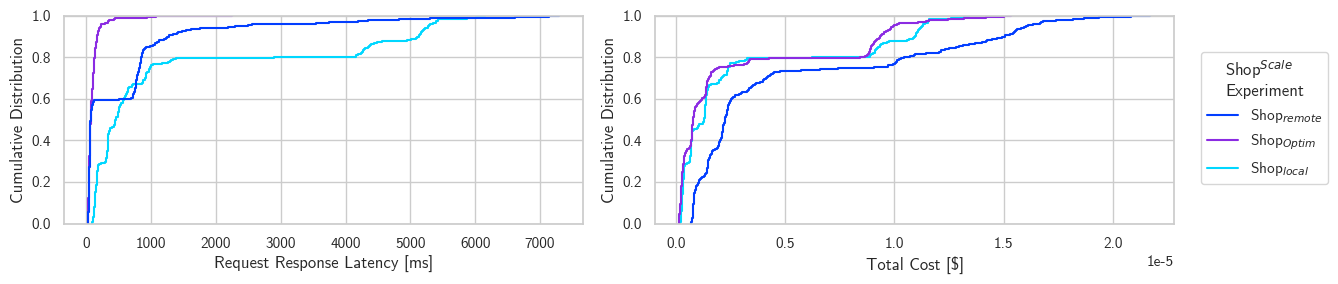

In [39]:
colors = [shop0, shop13_o, shopl]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,3))
#ax1.set_xlim(1400, 2200)
ax1.set_xlabel("Request Response Latency [ms]")
ax1.set_ylabel("Cumulative Distribution")
#ax2.set_xlim(0.000014, 0.000035)
ax2.set_xlabel("Total Cost [$]")
ax2.set_ylabel("Cumulative Distribution")

hue_order = ["Shop$_{remote}$", "Shop$_{Optim}$","Shop$_{local}$"]
sns.ecdfplot(ax=ax1, data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)
sns.ecdfplot(ax=ax2, data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroupLabel'], hue_order=hue_order, palette=colors, legend=None)


fig.legend(handles=reversed(ax2.get_lines()), labels=hue_order, title="Shop$^{Scale}$\nExperiment", ncol=1, loc="center right",  bbox_to_anchor=(0.12, 0.33, 1, 0.5))
save_fig(fig, "webshop/bursty")

In [40]:
printStats(grouped, fusion_groups_order)

------ overall
Mean: 651.7681281618887, Confidence Interval: (581.5853229318991 / 721.9509333918784), Median: 124.0 for rootDuration
Mean: 1494.582156133829, Confidence Interval: (1385.3658557467572 / 1603.7984565209006), Median: 628.0 for billedDuration
Mean: 3.653944160413978e-06, Confidence Interval: (3.4074483677494874e-06 / 3.900439953078469e-06), Median: 1.3866694399999999e-06 for totalCost
------ a_remote/['Shop$_{remote}$']
 minmem: [128]
Mean: 604.0773333333333, Confidence Interval: (493.45121479229596 / 714.7034518743707), Median: 65.0 for rootDuration
Mean: 2341.5306666666665, Confidence Interval: (2083.2217650899292 / 2599.839568243404), Median: 1053.0 for billedDuration
Mean: 4.995275412753067e-06, Confidence Interval: (4.444215320604713e-06 / 5.546335504901421e-06), Median: 2.2464044928e-06 for totalCost
------ b_local/['Shop$_{local}$']
 minmem: [128]
Mean: 1335.3413333333333, Confidence Interval: (1148.233230817938 / 1522.4494358487286), Median: 460.0 for rootDuration
M